In [1]:
# Non-stationary harmonic fit on observation data



In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
# import h5py
from scipy import signal



from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from soda.utils.harmonic_analysis import harmonic_fit_array

import matplotlib as mpl

In [2]:
%matplotlib notebook

In [3]:
# Load some data
# ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Gridded_Mooring_T_PILKIMTIS.nc'
# ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Fitted_Buoyancy_Tonly.nc'

# ds = xr.concat([xr.open_dataset(ncfile,group='PIL100_2012_a')['A_n'],
#     xr.open_dataset(ncfile,group='PIL100_2012_b')['A_n'],
#     #xr.open_dataset(ncfile,group='PIL100_2013')['A_n'],
#     xr.open_dataset(ncfile,group='PIL100_2014_a')['A_n'] ], dim='time')

# # Do some QC
# ds.loc['2012-05-23':'2012-07-31']=np.nan
# ds.loc['2014-06-08':'2014-06-14']=np.nan


In [4]:
# # Load some data
# ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Fitted_Buoyancy_Tonly.nc'

# ds = xr.concat([xr.open_dataset(ncfile,group='PIL200_2012_a')['A_n'],
#     xr.open_dataset(ncfile,group='PIL200_2012_b')['A_n'],
#     xr.open_dataset(ncfile,group='PIL200_2013_a')['A_n'],
#     xr.open_dataset(ncfile,group='PIL200_2013_b')['A_n'],

#     xr.open_dataset(ncfile,group='PIL100_2014_a')['A_n'] ], dim='time')

# # Do some QC
# ds.loc['2014-06-08':'2014-06-13']=np.nan
# # ds.loc['2014-06-08':'2014-06-14']=np.nan


In [88]:
# Load some data
# ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Gridded_Mooring_T_PILKIMTIS.nc'
def open_bfilt_dataset(ncfile, group):
    myds = xr.open_dataset(ncfile,group=group)['A_n']
    ts = timeseries(myds.time.values, myds.values)
    yfilt = ts.filt([33*3600,3*3600], btype='band')
    myds.data[:]=yfilt.T
    return myds

# ncfile = '~/Share/ARCHub/DATA/FIELD/IMOS/IMOS_Fitted_Buoyancy_Tonly.nc'
# ncfile = r'C:\Users\mrayson\cloudstor\Data\IMOS\IMOS_Fitted_Buoyancy_Tonly.nc'


###
# sitename = 'KIM200'
# ds = xr.concat([
#     open_bfilt_dataset(ncfile, 'KIM200_2012_b'),
#     open_bfilt_dataset(ncfile, 'KIM200_2013_a'),
#     open_bfilt_dataset(ncfile, 'KIM200_2013_b'),
#     open_bfilt_dataset(ncfile, 'KIM200_2014_a'),

#     ], dim='time')

# # Do some QC (KIM200)
# ds.loc['2013-07-02':'2013-07-21']=np.nan
# t1,t2 = '2012-07-01','2013-07-01'

###
sitename = 'PIL200'
ds = xr.concat([
    open_bfilt_dataset(ncfile, 'PIL200_2012_a'),
    open_bfilt_dataset(ncfile, 'PIL200_2012_b'),
    open_bfilt_dataset(ncfile, 'PIL200_2013_a'),
    open_bfilt_dataset(ncfile, 'PIL200_2013_b'),
    open_bfilt_dataset(ncfile, 'PIL200_2014_a'),
    ], dim='time')

#ds.loc['2013-07-01':'2013-07-26']=np.nan
t1,t2 = '2013-08-01','2014-09-01'


#(KIM400)
# ds.loc['2012-07-30':'2012-08-10']=np.nan
# ds.loc['2014-07-10':'2014-08-30']=np.nan

<IPython.core.display.Javascript object>


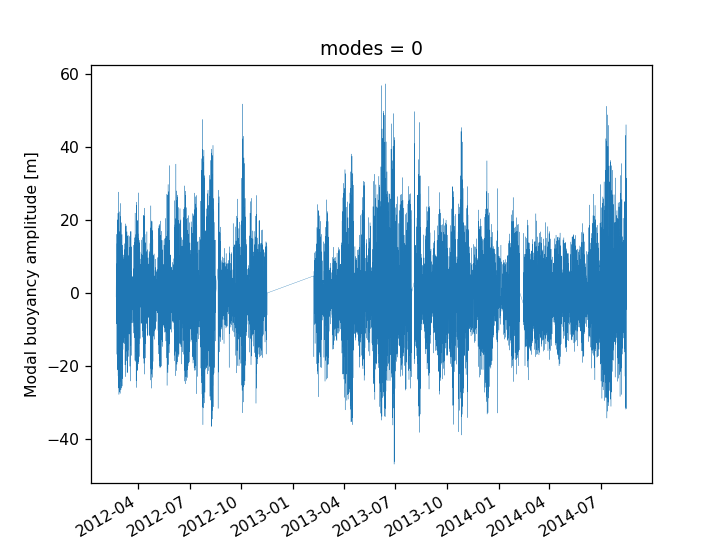

In [90]:
plt.figure()
ds[:,0].plot(lw=0.2)

In [91]:
def harmonic_pred(aa, Aa, Ba, omega, tdays):
    nomega = len(omega)
    nt = tdays.shape[0]
    amp = np.ones_like(tdays) * aa
    for ii in range(nomega):
        amp += Aa[...,ii]*np.cos(omega[ii]*tdays) + Ba[...,ii]*np.sin(omega[ii]*tdays)
    
    return amp


In [92]:
mode = 0
Xsel = ds[:,mode].sel(time=slice(t1,t2))
#Xsel.loc['2016-09-15':'2016-10-15']=np.nan
idx = ~np.isnan(Xsel.values)


X = Xsel.values[idx]
tnew = Xsel.time.values[idx]

# Break the time series up into chunks
trange = pd.date_range(tnew[0],tnew[-1],freq='30D').values
tmid = trange[0:-1] + 0.5*(trange[1:]-trange[0:-1])

tindex = np.zeros(tnew.shape, np.int)
ii=0
for t1,t2 in zip(trange[0:-1], trange[1:]):
    idx = (tnew>=t1) & (tnew<=t2)
    #print(t1,t2,sum(idx))

    tindex[idx] = ii
    ii+=1

c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\soda\utils\harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)


RMSE:  7.1810038147755675


<IPython.core.display.Javascript object>


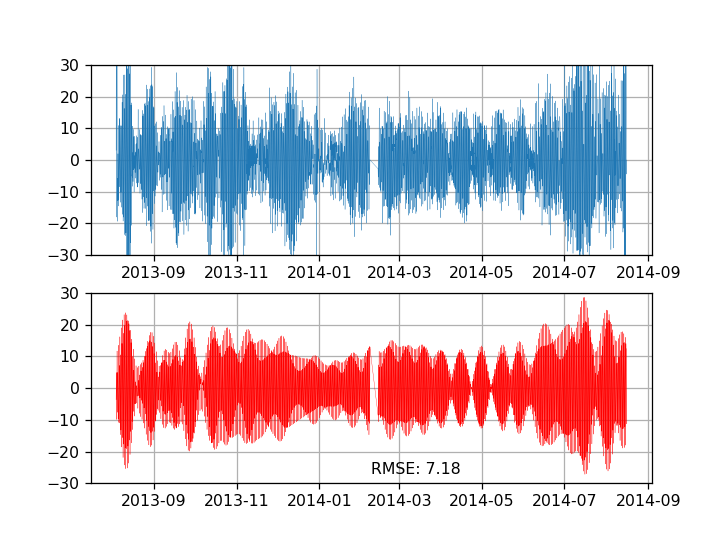

<IPython.core.display.Javascript object>


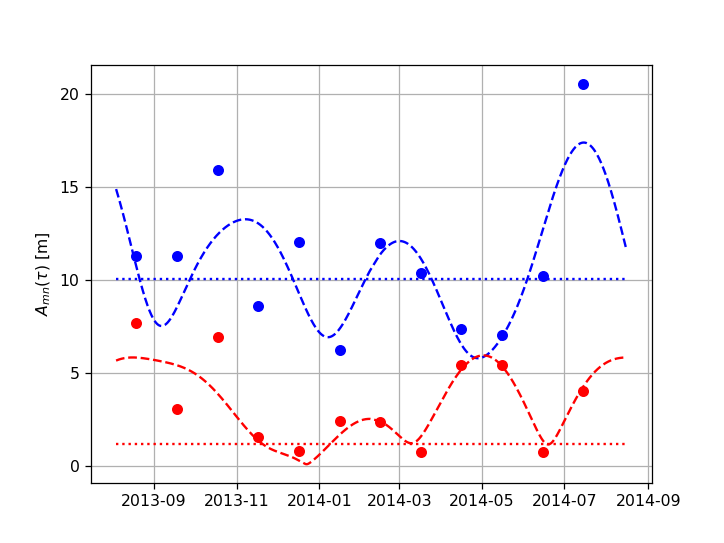

Text(0, 0.5, '$A_{mn}(\\tau)$ [m]')

In [93]:
tdaysec = 86400.

tidecons = ['M2','S2','N2','K1','O1',]
frq,names = getTideFreq(tidecons)
#frqlow = [2*np.pi/(365*tdaysec), 2*np.pi/(180*tdaysec), 2*np.pi/(120*tdaysec)]
omega_A = 2*np.pi/(365*tdaysec)
frqlow = [omega_A, 2*omega_A, 3*omega_A]


# Go through and do the fitting using least-squares
nfrq = len(frq)
nfrqlow = len(frqlow)

tsec = SecondsSince(tnew)
tseclow = SecondsSince(tmid)

nt = tsec.shape[0]
ntlow = tseclow.shape[0]

# 1) Fit the tide harmonics to each 30 d block
aa = np.zeros((ntlow,))
Aa = np.zeros((ntlow, nfrq))
Ba = np.zeros((ntlow, nfrq))

for ii in range(ntlow):
    idx = tindex == ii
    Y = harmonic_fit_array(X[idx], tsec[idx], frq, axis=0)
    aa[ii] = Y[0]
    Aa[ii,:] = Y[1::2]
    Ba[ii,:] = Y[2::2]


# 2) Fit the low-frequency harmonics to these harmonics
aa_l_r = np.zeros((nfrq,))
Aa_l_r = np.zeros((nfrqlow,nfrq))
Ba_l_r = np.zeros((nfrqlow,nfrq))

aa_l_i = np.zeros((nfrq,))
Aa_l_i = np.zeros((nfrqlow,nfrq))
Ba_l_i = np.zeros((nfrqlow,nfrq))

#Y = harmonic_fit_array(aa, tseclow, frqlow, axis=0)
#aa_l_r[:] = Y[1::2]
#aa_l_i[:] = Y[2::2]

Y = harmonic_fit_array(Aa, tseclow, frqlow, axis=0)
aa_l_r[:] = Y[0,:]
Aa_l_r[:] = Y[1::2,:]
Aa_l_i[:] = Y[2::2,:]

Y = harmonic_fit_array(Ba, tseclow, frqlow, axis=0)
aa_l_i[:] = Y[0,:]
Ba_l_r[:] = Y[1::2,:]
Ba_l_i[:] = Y[2::2,:]

## Prediction
# 3) Build the tidal harmonics as a time-series
Aa_pred = np.zeros((nt,nfrq))
Ba_pred = np.zeros((nt,nfrq))

for ii in range(nfrq):
    Aa_pred[:,ii] = harmonic_pred(aa_l_r[ii], Aa_l_r[:,ii], Aa_l_i[:,ii], frqlow, tsec)
    Ba_pred[:,ii] = harmonic_pred(aa_l_i[ii], Ba_l_r[:,ii], Ba_l_i[:,ii], frqlow, tsec)
    
# Aa_pred_A = np.zeros((nt,nfrq))
# Ba_pred_A = np.zeros((nt,nfrq))
# for ii in range(nfrq):
#     Aa_pred_A[:,ii] = harmonic_pred(aa_l_r[ii], [Aa_l_r[0,ii]], [Aa_l_i[0,ii]], [frqlow[0]], tsec)
#     Ba_pred_A[:,ii] = harmonic_pred(aa_l_i[ii], [Ba_l_r[0,ii]], [Ba_l_i[0,ii]], [frqlow[0]], tsec)    


# 4) Predict the raw amplitude
a0 = harmonic_pred(0, Aa_pred, Ba_pred, frq, tsec)

print('RMSE: ',rmse(X,a0))

plt.figure()
plt.subplot2grid((2,3),(0,0),colspan=3)
plt.plot(tnew,X,lw=0.2)
plt.ylim(-30,30)
plt.grid(b=True)

ax=plt.subplot2grid((2,3),(1,0),colspan=3)
plt.plot(tnew,a0,'r',lw=0.2)
plt.ylim(-30,30)
plt.text(0.5,0.05, 'RMSE: %1.2f'%(rmse(X,a0)), transform=ax.transAxes)
plt.grid(b=True)
# plt.subplot2grid((2,3),(0,2),rowspan=2)
# plt.hist(a0-X)

plt.figure()
ff = 0
plt.plot(tmid, np.abs(Aa[:,ff] + 1j*Ba[:,ff]),'bo')
plt.plot(tnew, np.abs(Aa_pred[:,ff] + 1j*Ba_pred[:,ff]),'b--')
mean_amp = np.abs(aa_l_r[ff] + 1j*aa_l_i[ff])
plt.plot([tnew[0],tnew[-1]], [mean_amp, mean_amp],'b:')

ff=1
plt.plot(tmid, np.abs(Aa[:,ff] + 1j*Ba[:,ff]),'ro')
plt.plot(tnew, np.abs(Aa_pred[:,ff] + 1j*Ba_pred[:,ff]),'r--')
mean_amp = np.abs(aa_l_r[ff] + 1j*aa_l_i[ff])
plt.plot([tnew[0],tnew[-1]], [mean_amp, mean_amp],'r:')
plt.grid(b=True)
plt.ylabel(r'$A_{mn}(\tau)$ [m]')
#
# plt.plot(tmid, np.abs(Aa[:,ff] + 1j*Ba[:,ff]),'ro')
# plt.plot(tnew, np.abs(Aa_pred[:,ff] + 1j*Ba_pred[:,ff]),'r--')



# Figure for AMOS talk

In [94]:
figpath = 'C:/Users/mrayson/Dropbox/ProjectsActive/ARCHub/DOCS-ARCHub-Dropbox/AMOS2020/'


<IPython.core.display.Javascript object>


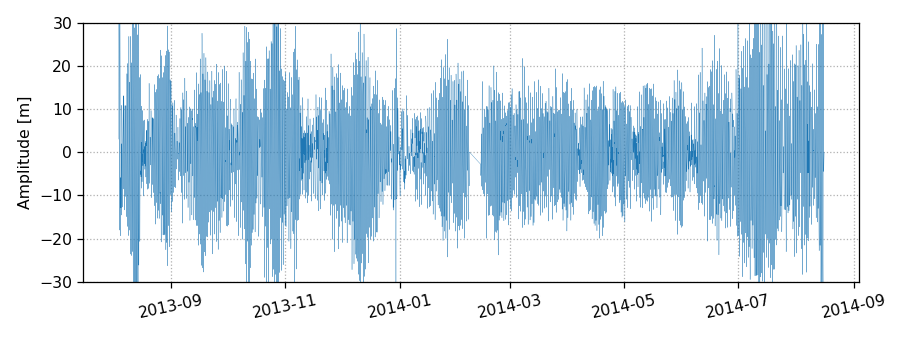

In [95]:
plt.figure(figsize=(8,3))
ax=plt.subplot(111)
plt.plot(tnew,X,lw=0.2)
plt.ylim(-30,30)
# plt.grid(b=True)
plt.ylabel('Amplitude [m]')
plt.xticks(rotation=12)
plt.grid(b=True, ls=':')
plt.tight_layout()

plt.savefig('{}/{}_a0.png'.format(figpath,sitename))

<IPython.core.display.Javascript object>


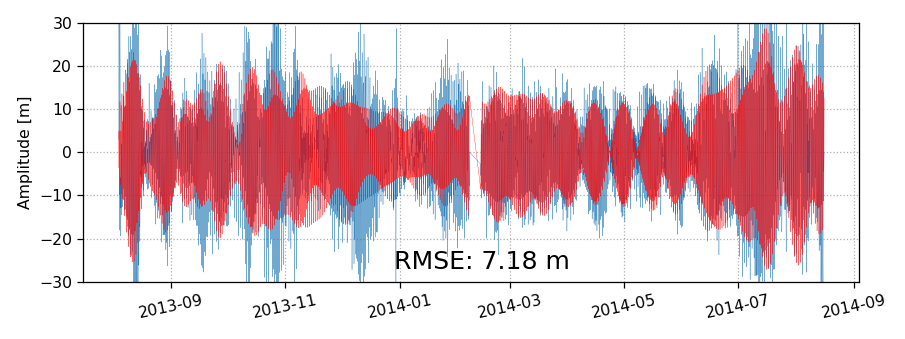

In [96]:
plt.figure(figsize=(8,3))
ax=plt.subplot(111)
plt.plot(tnew,X,lw=0.2)
plt.plot(tnew,a0,'r',lw=0.2)
plt.text(0.4,0.05, 'RMSE: %1.2f m'%(rmse(X,a0)), transform=ax.transAxes, fontsize=16)

plt.ylim(-30,30)
# plt.grid(b=True)
plt.ylabel('Amplitude [m]')
plt.xticks(rotation=12)
plt.grid(b=True, ls=':')
plt.tight_layout()

plt.savefig('{}/{}_a0_pred.png'.format(figpath,sitename))

<IPython.core.display.Javascript object>


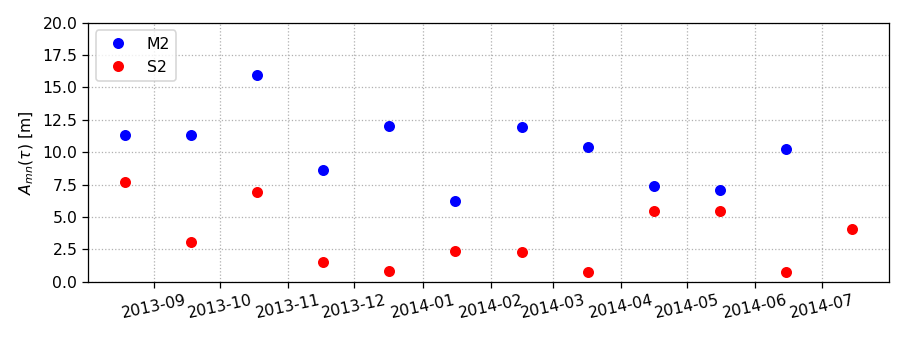

In [97]:
plt.figure(figsize=(8,3))
ff = 0
plt.plot(tmid, np.abs(Aa[:,ff] + 1j*Ba[:,ff]),'bo')

ff=1
plt.plot(tmid, np.abs(Aa[:,ff] + 1j*Ba[:,ff]),'ro')
plt.ylim(0,20)
plt.ylabel(r'$A_{mn}(\tau)$ [m]')
plt.xticks(rotation=12)
plt.grid(b=True, ls=':')
plt.legend(('M2','S2'))
plt.tight_layout()

plt.savefig('{}/{}_A_mn.png'.format(figpath, sitename))

<IPython.core.display.Javascript object>


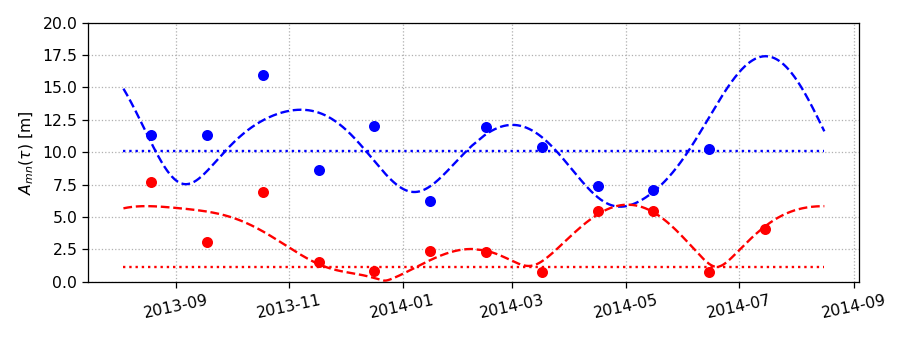

In [98]:
plt.figure(figsize=(8,3))

ff=0
plt.plot(tmid, np.abs(Aa[:,ff] + 1j*Ba[:,ff]),'bo')
plt.plot(tnew, np.abs(Aa_pred[:,ff] + 1j*Ba_pred[:,ff]),'b--')
mean_amp = np.abs(aa_l_r[ff] + 1j*aa_l_i[ff])
plt.plot([tnew[0],tnew[-1]], [mean_amp, mean_amp],'b:')

ff=1
plt.plot(tmid, np.abs(Aa[:,ff] + 1j*Ba[:,ff]),'ro')
plt.plot(tnew, np.abs(Aa_pred[:,ff] + 1j*Ba_pred[:,ff]),'r--')
mean_amp = np.abs(aa_l_r[ff] + 1j*aa_l_i[ff])

plt.plot([tnew[0],tnew[-1]], [mean_amp, mean_amp],'r:')
plt.ylim(0,20)
plt.ylabel(r'$A_{mn}(\tau)$ [m]')
plt.xticks(rotation=12)
plt.grid(b=True, ls=':')
plt.tight_layout()

plt.savefig('{}/{}_A_pred.png'.format(figpath, sitename))

# Do the fit using all of the frequencies (i.e. no windowing)

In [99]:
frq_all =[]
for ff in frq:
    for n in range(-3,4):
        frq_all.append(ff+n*omega_A)
        
Y = harmonic_fit_array(X, tsec, frq_all, axis=0)
aa = Y[0]
Aa = Y[1::2]
Ba = Y[2::2]

len(frq_all)
a0_all = harmonic_pred(aa, Aa, Ba, frq_all, tsec)

# Fit with no nonstationary componenent
tidecons = ['M2','S2','N2','K1','O1','MA2','MB2']
frqstat,names = getTideFreq(tidecons)

Y = harmonic_fit_array(X, tsec, frqstat, axis=0)
aa = Y[0]
Aa = Y[1::2]
Ba = Y[2::2]

len(frq_all)
a0_stat = harmonic_pred(aa, Aa, Ba, frqstat, tsec)


c:\users\mrayson\miniconda3\envs\soda\lib\site-packages\soda\utils\harmonic_analysis.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,X)


<IPython.core.display.Javascript object>


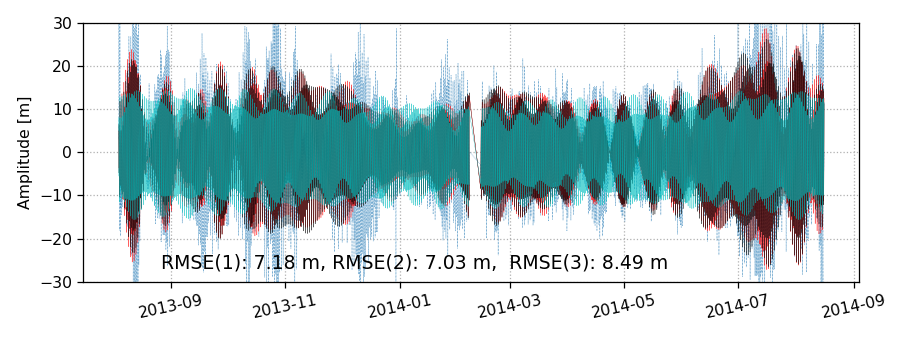

In [100]:
plt.figure(figsize=(8,3))
ax=plt.subplot(111)
plt.plot(tnew,X,lw=0.34,ls=':')
plt.plot(tnew,a0,'r',lw=0.2)
plt.plot(tnew,a0_all,'k',lw=0.2)
plt.plot(tnew,a0_stat,'c',lw=0.2)


plt.text(0.1,0.05, 'RMSE(1): %1.2f m, RMSE(2): %1.2f m,  RMSE(3): %1.2f m'%\
         (rmse(X,a0),rmse(X,a0_all),rmse(X,a0_stat)),\
         transform=ax.transAxes, fontsize=12)

plt.ylim(-30,30)
# plt.grid(b=True)
plt.ylabel('Amplitude [m]')
plt.xticks(rotation=12)
plt.grid(b=True, ls=':')
plt.tight_layout()

#plt.savefig('{}/KIM200_a0_pred.png'.format(figpath))

<IPython.core.display.Javascript object>


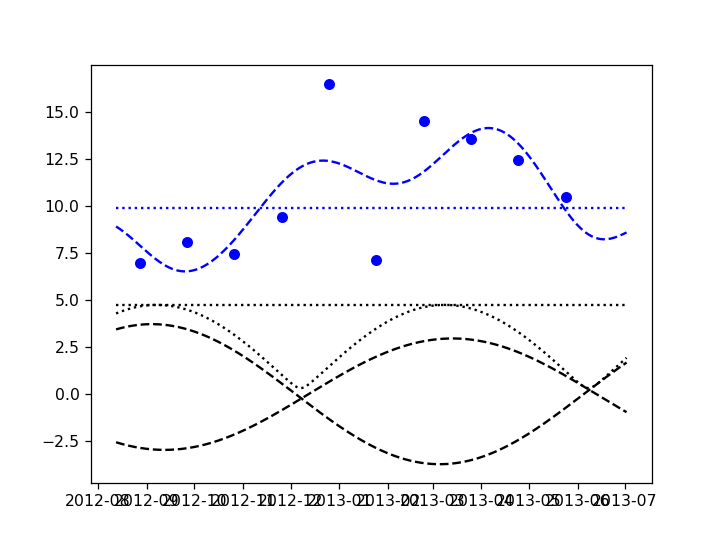

-1.3569745750254294 -3.4605436836588517 0.6866320250093432 2.8760090740626643
6.673926047961813


In [196]:
ii=0
kk=0
Aa_l_r_tmp = 1*Aa_l_r
Aa_l_i_tmp = 1*Aa_l_i
Ba_l_r_tmp = 1*Ba_l_r
Ba_l_i_tmp = 1*Ba_l_i
for k in range(nfrqlow):
    if k != kk:
        Aa_l_r_tmp[k,ii] = 0
        Aa_l_i_tmp[k,ii] = 0
        Ba_l_r_tmp[k,ii] = 0
        Ba_l_i_tmp[k,ii] = 0

        
Aa_pred_kk = harmonic_pred(0, Aa_l_r_tmp[:,ii], Aa_l_i_tmp[:,ii], frqlow, tsec)
Ba_pred_kk = harmonic_pred(0, Ba_l_r_tmp[:,ii], Ba_l_i_tmp[:,ii], frqlow, tsec)

# Plot the M2 annual harmonic only
ff=0
plt.figure()
plt.plot(tmid, np.abs(Aa[:,ff] + 1j*Ba[:,ff]),'bo')
plt.plot(tnew, np.abs(Aa_pred[:,ff] + 1j*Ba_pred[:,ff]),'b--')



mean_amp = np.abs(aa_l_r[ff] + 1j*aa_l_i[ff])
plt.plot([tnew[0],tnew[-1]], [mean_amp, mean_amp],'b:')

plt.plot(tnew, Aa_pred_kk ,'k--')
plt.plot(tnew, Ba_pred_kk ,'k--')

def ht(a,b):
    return np.abs( (a-b) + 1j*(a+b))
    

plt.plot(tnew, np.abs(Aa_pred_kk + 1j*Ba_pred_kk ),'k:')
print(Aa_l_r[ff,0], Aa_l_i[ff,0],Ba_l_r[ff,0], Ba_l_i[ff,0])

# Calculate the amplitude
print(np.abs(Aa_l_r[ff,0]+ 1j*Aa_l_i[ff,0]) + np.abs(Ba_l_r[ff,0]+1j* Ba_l_i[ff,0]))

A_re = Aa_l_r[ff,0] + 1j*Aa_l_i[ff,0]
A_im = Ba_l_r[ff,0] + 1j*Ba_l_i[ff,0]
A_amp = np.abs( np.abs(A_re) + 1j*np.abs(A_im) )
plt.plot([tnew[0],tnew[-1]], [A_amp, A_amp],'k:')


In [170]:
np.sqrt(3.7**2+2.9**2)

4.701063709417263